# Model Predictions

Use the best model from the experiments to estimate generalization performance on the test set.

In [1]:
%load_ext autoreload
%autoreload 2

from utils import code
from plot_libraries import setup_graphics
from datasets import get_data

In [2]:
#Main Libraries
import os, random, re, sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load

#utils
from plot_libraries import setup_graphics,plot_corr_matrix


#corr matrix
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance

#Data transform (pipeline)
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.calibration import CalibratedClassifierCV



# Model evaluation
import scikitplot as skplt
from sklearn.metrics import make_scorer, roc_auc_score, brier_score_loss, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, cross_val_predict
from evaluation import plot_learning_curve, evaluate_model, plot_confusion_matrix, evaluate_model_skopt 
from evaluation import plot_feature_permutation, plot_calibration_curve, get_cv_scores
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Support
import parameters as params
from model import Model, build_tuned_model
from datasets import get_data
from experiments import experiment_11, experiment_2, get_scorer
from sklearn.metrics import make_scorer, roc_auc_score, brier_score_loss, classification_report, confusion_matrix, f1_score, recall_score

#setup
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
sns.set()
%matplotlib inline
setup_graphics()

## Get Data

Load the training and test sets

In [3]:
X_future, y_future = get_data('../data/PredDF.csv')
X, y = get_data('../data/trainDF.csv')

### Loading Pipelines

In [4]:
pipeline2 = experiment_2.get_full_pipeline()
ps = pipeline2.fit_transform(X).shape
print('Instances: {:,}, Features: {}'.format(ps[0], ps[1]))

Instances: 1,849, Features: 12


In [5]:
pipeline1 = experiment_11.get_full_pipeline()
ps = pipeline1.fit_transform(X).shape
print('Instances: {:,}, Features: {}'.format(ps[0], ps[1]))

Instances: 1,849, Features: 62


In [6]:
#setup
scorer = make_scorer(roc_auc_score)
results, res_cv, res_calibrated, n_iter = list(), dict(), dict(), 100

#### ML Models

Stacking Structure:

Level-1:

* LogisticRegression(pipeline1 & RandomizedSearchCV=5, n_iter=100)
* SGDClassifier(pipeline1 & RandomizedSearchCV=5, n_iter=100)
* XGBClassifier(pipeline2 & BayesSearchCV=5, n_iter=100)
* LGBMClassifier(pipeline2 & BayesSearchCV=5, n_iter=100)
* KNeighborsClassifier(pipeline1 & RandomizedSearchCV=5, n_iter=100)

**Logistic Regression**
* LogisticRegression(pipeline1 & RandomizedSearchCV=5, n_iter=100)

In [8]:
from sklearn.linear_model import LogisticRegression
import bayes_grid_models as bgrid
import param_grid_models as pgrid

result = evaluate_model(X, y, 'lr', 
                        LogisticRegression(), 
                        pgrid.lr_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline1)
results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])

==> Starting 5-fold cross validation for lr model, 1849 examples
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.1s


==> Elapsed seconds: 26.384
Best lr model: LogisticRegression(C=0.01, class_weight={0: 1, 1: 10}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Best lr score (val): 0.523


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.2s finished


**SGD Classifier**

* SGDClassifier(pipeline1 & RandomizedSearchCV=5, n_iter=100)

In [9]:
from sklearn.linear_model import SGDClassifier

result = evaluate_model(X, y, 'sgd', 
                        SGDClassifier(), 
                        pgrid.sgd_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline1)

results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])

==> Starting 5-fold cross validation for sgd model, 1849 examples
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   13.1s


==> Elapsed seconds: 21.097
Best sgd model: SGDClassifier(alpha=0.1, average=False, class_weight={0: 1, 1: 10},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best sgd score (val): 0.527


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.0s finished


**XGBoost**

* XGBClassifier(pipeline2 & BayesSearchCV=5, n_iter=100)

In [10]:
from xgboost import XGBClassifier

result = evaluate_model_skopt(X, y, 'xgb', 
                        XGBClassifier(), 
                        bgrid.xgb_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline2)

results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])

==> Starting 5-fold cross validation for xgb model, 1849 examples
==> Elapsed seconds: 627.958
Best xgb model: XGBClassifier(base_score=0.5, booster=None,
              colsample_bylevel=0.9966985053530335, colsample_bynode=1,
              colsample_bytree=0.6107442614214202, gamma=4.38526680311963,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.5951103846297292, max_delta_step=0, max_depth=5,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=111, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.6073332669397363, reg_lambda=0.010925407546523507,
              scale_pos_weight=9548, subsample=0.6211958518992106,
              tree_method=None, validate_parameters=False, verbosity=None)
Best xgb score (val): 0.543


**Light GBM**

* LGBMClassifier(pipeline2 & BayesSearchCV=5, n_iter=100)

In [11]:
from lightgbm import LGBMClassifier

result = evaluate_model_skopt(X, y, 'lgbm',
                        LGBMClassifier(),
                        bgrid.lgbm_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline2)

results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])

==> Starting 5-fold cross validation for lgbm model, 1849 examples
==> Elapsed seconds: 599.771
Best lgbm model: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=False,
               learning_rate=0.0693926142021155, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=2, objective=None,
               random_state=None, reg_alpha=0.001, reg_lambda=1.0, silent=True,
               subsample=0.5, subsample_for_bin=300000, subsample_freq=0)
Best lgbm score (val): 0.542


**K-Nearest Neighboors**

* KNeighborsClassifier(pipeline1 & RandomizedSearchCV=5, n_iter=100)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

result = evaluate_model(X, y, 'knn', 
                        KNeighborsClassifier(), 
                        pgrid.knn_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline1)

results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])

==> Starting 5-fold cross validation for knn model, 1849 examples
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min


==> Elapsed seconds: 93.994
Best knn model: KNeighborsClassifier(algorithm='auto', leaf_size=28, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')
Best knn score (val): 0.524


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


In [26]:
def get_full_pipeline(results, name): 
    model = list(filter(lambda x: x[1] == name, results))[0][0]
    PATH = '../models_pkl/experiment-2.1-stacking_'+name+'.pkl'
    model.save(PATH)
    model_pipeline = model.get_model_pipeline()
    return model_pipeline

In [27]:
level1_clf = []
clf_names = ['lr', 'sgd', 'xgb', 'lgbm', 'knn']
for name in clf_names:
    level1_clf.append(get_full_pipeline(results, name))

-------------------
-------------------

### Stacking

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection

In [12]:
models_l1, level1_clf = {}, []
clf_names = ['lr', 'sgd', 'xgb', 'lgbm', 'knn', 'StackingClassifier']

for name in clf_names[:-1]:
    PATH = '../models_pkl/experiment-2.1-stacking_'+name+'.pkl'
    model = Model.load(PATH)
    model_pipeline = model.get_model_pipeline()
    level1_clf.append(model_pipeline)

In [9]:
%%time
from sklearn.model_selection import RandomizedSearchCV

model_l2 = LogisticRegression()
stack_clf = level1_clf.copy()
sclf1 = StackingCVClassifier(classifiers=level1_clf, 
                            meta_classifier=model_l2,
                            store_train_meta_features=True,
                            random_state=20, cv=5,
                            verbose=0, use_probas=False)





params = {
  'meta_classifier__C': np.logspace(-3, 2, 6), 
  'meta_classifier__max_iter': [10, 50, 100, 200, 500],
  'meta_classifier__penalty':  ['l1', 'l2'], 
  'meta_classifier__solver': ['liblinear'],
  'meta_classifier__tol': [0.0001, 0.001 ,0.01],
  'meta_classifier__class_weight': [None, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, 'balanced']
}



grid = RandomizedSearchCV(estimator=sclf1, 
                    param_distributions=params, 
                    scoring=scorer,
                    cv=5,
                    n_iter=50,
                    refit=True,
                    verbose=0)

grid.fit(X, y)

print('Best parameters: %s' % grid.best_params_)
print('AUC: %.3f' % grid.best_score_)

Best parameters: {'meta_classifier__tol': 0.0001, 'meta_classifier__solver': 'liblinear', 'meta_classifier__penalty': 'l2', 'meta_classifier__max_iter': 100, 'meta_classifier__class_weight': 'balanced', 'meta_classifier__C': 0.01}
AUC: 0.576
CPU times: user 27min 21s, sys: 3min 19s, total: 30min 41s
Wall time: 18min 36s


In [13]:
%%time

best_params ={'meta_classifier__tol': 0.0001,
              'meta_classifier__solver': 'liblinear',
              'meta_classifier__penalty': 'l2',
              'meta_classifier__max_iter': 100,
              'meta_classifier__class_weight': 'balanced',
              'meta_classifier__C': 0.01}


best_model = list(best_params.values())
#best_model = list(grid.best_params_.values())
model_l2 = LogisticRegression(tol=best_model[0],
                              solver=best_model[1],
                              penalty=best_model[2],
                              max_iter =best_model[3],
                              class_weight=best_model[4],
                              C=best_model[5])


stack_clf = level1_clf.copy()
sclf2 = StackingCVClassifier(classifiers=level1_clf, 
                            meta_classifier=model_l2,
                            store_train_meta_features=True,
                            random_state=20, cv=5,
                            verbose=0, use_probas=False)


stack_clf.append(sclf2)                                      
print('5-fold cross validation:\n')
scores = model_selection.cross_val_score(sclf2, X, y, cv=5, scoring=scorer)
print("AUC: %0.3f (+/- %0.2f) [%s]"  % (scores.mean(), scores.std(), clf_names[-1]))

5-fold cross validation:

AUC: 0.575 (+/- 0.05) [StackingClassifier]
CPU times: user 41 s, sys: 1.06 s, total: 42.1 s
Wall time: 14.2 s


              precision    recall  f1-score   support

           0       0.95      0.08      0.15      1534
           1       0.18      0.98      0.30       315

    accuracy                           0.24      1849
   macro avg       0.56      0.53      0.23      1849
weighted avg       0.82      0.24      0.18      1849



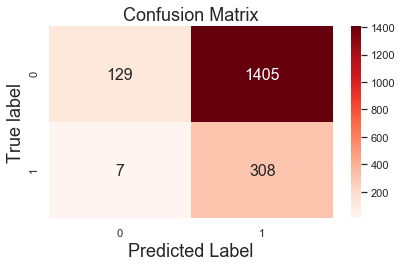

In [14]:
sclf2.fit(X, y)
l2 = sclf2.predict(X); setup_graphics()  
plot_confusion_matrix(y, l2)

### Making Predictions

In [6]:
model = Model.load('../models_pkl/final-model.pkl')
model.model

LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=0.6,
               importance_type='split', is_unbalance=False, learning_rate=1.0,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=2,
               objective=None, random_state=None, reg_alpha=1.0, reg_lambda=1.0,
               silent=True, subsample=0.5, subsample_for_bin=300000,
               subsample_freq=0)

In [23]:
from joblib import load
model_l2 = load('../models_pkl/experiment-2.1-stacking_80_L2.pkl')
model_l2.meta_clf_
#model_l2.clfs_

LogisticRegression(C=10.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1534
           1       0.60      0.83      0.69       315

    accuracy                           0.88      1849
   macro avg       0.78      0.86      0.81      1849
weighted avg       0.90      0.88      0.88      1849



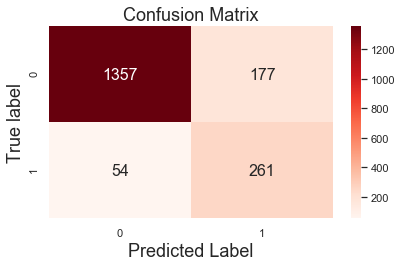

In [24]:
preds = model_l2.predict(X)
probs = model_l2.predict_proba(X)
plot_confusion_matrix(y, preds)

### From Predictions Set

regular:  1920


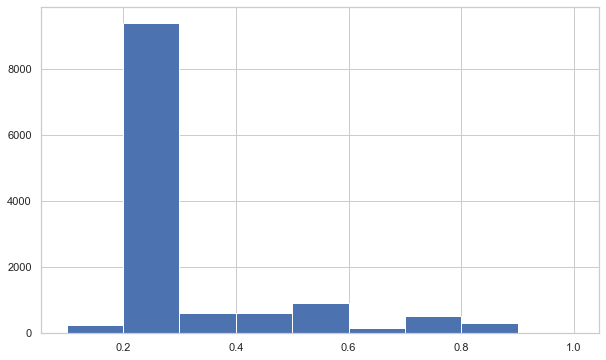

In [25]:
preds = model_l2.predict(X_future)
probs = model_l2.predict_proba(X_future)
print("regular: ",sum(preds))
plt.hist(probs[:,1], bins=[i/10 for i in range(1,11)]); plt.show()

#### Saving Predictions

In [26]:
X_future['Class_Predicted'] = preds
X_future['Class1_Prob'] = probs[:,1]

In [27]:
X_csv = X_future[['Class_Predicted', 'Class1_Prob']]
X_csv['Class1_Prob'] = X_csv.Class1_Prob.round(4)

In [28]:
X_csv.to_csv('../data/FinalPredictions_stack.csv', sep=',', index=True)
X_Pos = X_future[X_future.Class_Predicted == 1]

In [29]:
X_Pos.sort_values(by=['Account_ICP_Tier'], ascending=False).head(10)

,Activities_Last_30_Days,Employees,ZoomInfo_Employee_Range,ZoomInfo_Revenue_Range,Organic_Visits,Pct_Organic_Visits,SEO_Visits,URLs_Indexed,ZoomInfo_Global_HQ_Country,Annual_Revenue_converted,Adjusted_Industry,Account_ICP_Score,Account_ICP_Tier,Page_Count,Page_Count_Range,Alexa_Rank,Parent_Account_Status,Class_Predicted,Class1_Prob
Account_ID,,,,,,,,,,,,,,,,,,,
0011p00002NOMRq,0.0,1000.0,"500 - 1,000",$100 mil. - $250 mil.,1.187295e+06,0.27,1.187295e+06,1560000.0,US,2.500000e+08,Retail,79.167,Tier S,1.560000e+06,>1M,143332.0,unknown,1,0.675555
001240000131stQ,0.0,30000.0,"Over 10,000",Over $5 bil.,2.096058e+07,0.27,2.478502e+07,209000.0,US,3.240600e+10,Other,70.833,Tier S,2.301000e+05,Between 100K and 250K,3689.0,Active Customer,1,0.833489
0011p00002SeS3s,0.0,1000.0,20 - 50,$5 mil. - $10 mil.,3.830000e+02,0.02,3.830000e+02,87.0,US,1.000000e+07,Media,37.500,Tier S,8.700000e+01,<500,1000001.0,unknown,1,0.554166
0012400000PCkjg,0.0,10000.0,"Over 10,000",Over $5 bil.,9.567800e+04,0.29,2.020233e+08,0.0,US,1.000000e+09,Media,100.000,Tier S,1.254988e+09,>1M,52537.0,unknown,1,0.749258
0012400001OKBSP,0.0,1000.0,100 - 250,$1 bil. - $5 bil.,1.662807e+09,NaN,1.662807e+09,834000.0,non_US,1.111300e+08,Classified,91.667,Tier S,8.340000e+05,Between 500K and 1M,13476.0,Prospect,1,0.833489
0011p00001SfWoz,10.0,10000.0,"Over 10,000",Over $5 bil.,2.723295e+06,0.40,2.838841e+06,50800.0,US,1.000000e+09,Travel,70.833,Tier S,6.950000e+04,Between 50K and 100K,6350.0,Prospect,1,0.554166
0011p00001UTsrK,0.0,5000.0,unknown,unknown,1.655507e+06,0.32,1.655507e+06,935000.0,non_US,1.311578e+06,Retail,87.500,Tier S,9.350000e+05,Between 500K and 1M,1000001.0,unknown,1,0.601027
0011p00002Q4LKs,0.0,10000.0,"Over 10,000",Over $5 bil.,8.109770e+05,NaN,8.109770e+05,37200.0,US,1.000000e+07,Retail,50.000,Tier S,3.720000e+04,Between 10K and 50K,35481.0,Prospect,1,0.554166
0011p00002Q4LHP,0.0,66421.0,"Over 10,000",Over $5 bil.,3.977445e+07,0.41,9.046147e+07,28900000.0,non_US,5.190000e+10,Classified,91.667,Tier S,3.107290e+07,>1M,1000001.0,unknown,1,0.833489


In [30]:
X_future['Account_ICP_Tier'].value_counts()

Tier C    8144
Tier B    3795
Tier A     825
Tier S      41
Name: Account_ICP_Tier, dtype: int64

In [31]:
X_Pos['Account_ICP_Tier'].value_counts()

Tier B    836
Tier C    826
Tier A    248
Tier S     10
Name: Account_ICP_Tier, dtype: int64

In [34]:
X_Pos.sort_values(by=['Class1_Prob'], ascending=False).head(10)

,Activities_Last_30_Days,Employees,ZoomInfo_Employee_Range,ZoomInfo_Revenue_Range,Organic_Visits,Pct_Organic_Visits,SEO_Visits,URLs_Indexed,ZoomInfo_Global_HQ_Country,Annual_Revenue_converted,Adjusted_Industry,Account_ICP_Score,Account_ICP_Tier,Page_Count,Page_Count_Range,Alexa_Rank,Parent_Account_Status,Class_Predicted,Class1_Prob
Account_ID,,,,,,,,,,,,,,,,,,,
0011p00002Q4RB6,0.0,10.0,50 - 100,$10 mil. - $25 mil.,3003051.0,0.35,3003051.0,184000.0,US,1.000000e+07,Media,75.000,Tier B,184000.0,Between 100K and 250K,1000001.0,Prospect,1,0.833489
0011p00002Q4Ona,0.0,200.0,50 - 100,$10 mil. - $25 mil.,161701.0,0.40,161701.0,152000.0,US,1.000000e+06,Media,58.333,Tier C,152000.0,Between 100K and 250K,209362.0,Prospect,1,0.833489
0011p00001SgdyJ,0.0,200.0,"1,000 - 5,000",$1 bil. - $5 bil.,1245253.0,0.34,1245253.0,64600.0,US,1.000000e+07,Retail,62.500,Tier B,64600.0,Between 50K and 100K,11646.0,Prospect,1,0.833489
0011p00002SeURm,0.0,200.0,50 - 100,$10 mil. - $25 mil.,108909.0,0.44,108909.0,751000.0,US,1.000000e+06,Media,58.333,Tier C,751000.0,Between 500K and 1M,1000001.0,Prospect,1,0.833489
0011p00002SeUyc,0.0,50.0,100 - 250,unknown,213323.0,0.22,213323.0,1110000.0,US,5.000000e+07,Classified,70.833,Tier C,1110000.0,>1M,1000001.0,Active Customer,1,0.833489
0011p00001o7qn9,0.0,200.0,"Over 10,000",Over $5 bil.,15177584.0,NaN,15177584.0,4880000.0,US,1.000000e+08,Media,100.000,Tier B,4880000.0,>1M,911.0,Active Customer,1,0.833489
0011p00002SelFD,0.0,200.0,unknown,unknown,1008908.0,0.48,1008908.0,903000.0,non_US,5.000000e+07,Media,75.000,Tier B,903000.0,Between 500K and 1M,1000001.0,Prospect,1,0.833489
0011p00001RPVZQ,0.0,1000.0,unknown,unknown,281411.0,0.61,281411.0,108000.0,non_US,2.778250e+08,Retail,70.833,Tier B,108000.0,Between 100K and 250K,15592.0,Prospect,1,0.833489
0011p00001hpedN,0.0,500.0,250 - 500,unknown,76421878.0,0.62,82533995.0,NaN,US,5.000000e+07,Media,66.667,Tier B,NaN,unknown,1000001.0,Prospect,1,0.833489


In [36]:
X_Pos['Class1_Prob'].value_counts()

0.554166    631
0.749258    395
0.833489    303
0.544117    201
0.675555    107
0.761628     86
0.570645     71
0.783620     43
0.683734     27
0.823987     17
0.601027     13
0.527463     10
0.698033      8
0.660709      6
0.772050      2
Name: Class1_Prob, dtype: int64

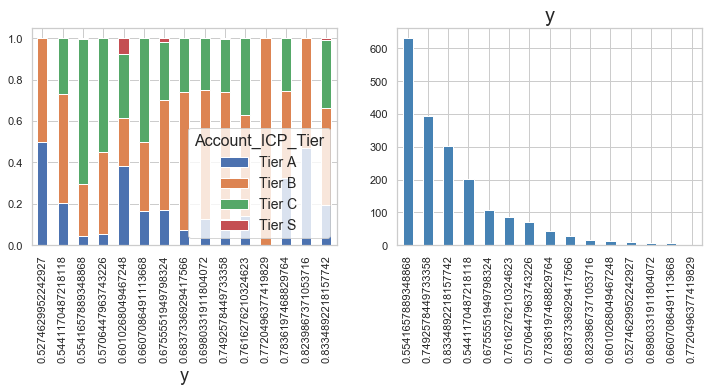

In [51]:
for attr in ['y']:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
  outcome_counts = X_Pos.groupby([attr, 'Account_ICP_Tier']).size().rename('count').reset_index()
  by_outcome = outcome_counts.pivot(columns='Account_ICP_Tier', values='count', index=attr)
  # Plot the proportions
  by_outcome.div(by_outcome.sum(1), axis=0).plot.bar(stacked=True, ax=ax1)
  # Plot the counts
  X_Pos[attr].value_counts().plot.bar(ax=ax2, legend=False,color='steelblue')
  #print('Support (%s)\n' % attr)
  #print(X[attr].value_counts(), '\n')
  plt.title(attr)

In [48]:
X_Pos['y'] = X_Pos['Class1_Prob'].astype('category')

In [44]:
X_Pos.groupby([attr, 'y'])